In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
from numpy.linalg import inv
from numpy import array, matrix, array_equal, all
from scipy.optimize import minimize
import time

In [3]:
# SCRIPT Problem_R

# In this script, I define the different parameters of the network (number of arcs, nodes, reservoirs). I also define 
# the structure of the graph, the resistance of the different arcs, ...
# YOU SHOULD NOT REASSIGN THE VARIABLES DEFINED IN THIS SCRIPT.

# Name of the network
Name='Realistic'

#Dimension of the network
n=22 #Number of arcs
m=16 #Number of nodes
mr=3 #Number of nodes where you have a reservoir
md=m-mr #Number of nodes that require water.

#Definition of the graph
#Nodes number
orig=np.array([1, 2, 3, 4, 5, 6, 7,8, 8, 9, 10, 11, 13, 1, 2, 4, 5, 7, 8, 14, 2, 10])
dest=np.array([4,16,15,5,6,10,16,9,12,10,11,14,15,16,6,8,9,11,13,15,4,13])

#Coordinate of the nodes
absn=np.array([11,18, 38, 4,8,15,26,4,10,19,26,7,21,33,33,16])
ordn=np.array([28,21,8,21,17,17,26,9,13,13,18,4,9,18,12,24])

#Resistance of the arcs
r=np.array([100, 10, 1000, 100, 100, 10, 1000, 100, 1000, 100, 1000, 1000, 1000, 10, 10, 100, 100, 1000, 100, 1000, 100,10])

#Pressure for the reservoirs (in meters)
pr=np.array([105,104,110])

#Demanding flow
fd=np.array([0.08, -1.3, 0.13, 0.09, 0.16, 0.14, 0.12, 0.07, 0.17, 0.11, 0.25, 0.01, 0.13])

In [4]:
# SCRIPT Structures_R

# In this script, I compute the incidence matrix. Then using the Kirchhoff's law, I compute the different variables
# which are used in the function we want to minimize.

#Incidence matrix
A=np.zeros((m,n))
for l in range(0, n):
    A[orig[l]-1,l]=-1 #We must not forget that in Python, we start at 0...
    A[dest[l]-1,l]=1

#Extraction of tree and cotree matrices
Ar=A[0:mr,:]
Ad=A[mr:m,:]
AdT=Ad[:,0:md]
AdI=inv(AdT)
AdC=Ad[:,md:n]

#Incidence matrix arcs-loops
B=np.concatenate((-np.dot(AdI,AdC),np.eye(n-md,n-md)),axis=0)

#Vector q_0
q0=np.zeros(n)
for l in range(0, md):
    RR=np.dot(AdI,fd)
    q0[l]=RR[l]
    
for l in range(md, n):
    q0[l]=0

q0=q0.T

In [5]:
def Visualg(logG,logP,Cost):
#This function plots the results obtained using the different algorithms
#log G is an array that contains the log10 of the cost function gradient norm for each iteration of the algorithm
#log P is an array that contains the log10 of the gradient step for each iteration of the algorithm
#Cost is an array that contains the value of the cost function.
#log G is a good way to check that the gradient converges to 0
#log P is a good way to check that the algorithm has a good performance.

    ndata=np.size(logG)
    absX=range(0,ndata)
    plt.figure(1)
    plt.plot(absX, logG)
    plt.xlabel("iteration nb")
    plt.ylabel("log(|G|)")
    plt.title("Evolution of the gradient norm (log scale)")
    plt.show()
    
    plt.figure(2)
    plt.plot(absX, logP)
    plt.xlabel("iteration nb")
    plt.ylabel("log(|alpha|)")
    plt.title("Evolution of the gradient step (log scale)")
    plt.show()
    
    plt.figure(3)
    plt.plot(absX, Cost)
    plt.xlabel("iteration nb")
    plt.ylabel("Cost")
    plt.title("Evolution of the Cost")
    plt.show()

In [6]:
#QUESTION 1: F and G
def OraclePG(qc,ind):
    #This function should return the value of the function in qc (ind=2), the value of the gradient in qc (ind=3) 
    #or both (ind=4)
        
    if ind == 2: 
        f1 = q0 + np.dot(B,qc) 
        f2 = np.multiply(np.multiply(r,q0+np.dot(B,qc)),abs(q0+np.dot(B,qc)))
        f3 = np.dot(Ar,q0+np.dot(B,qc))
        F = 1/3*np.dot(f1,f2) + np.dot(pr,f3)
        return F
              
    elif ind == 3: 
        f2 = np.multiply(np.multiply(r,q0+np.dot(B,qc)),abs(q0+np.dot(B,qc)))
        G = np.dot(B.T,f2) + np.dot(np.dot(Ar,B).T,pr)
        return G
    
    elif ind == 4: 
        f1 = q0 + np.dot(B,qc) 
        f2 = np.multiply(np.multiply(r,q0+np.dot(B,qc)),abs(q0+np.dot(B,qc)))
        f3 = np.dot(Ar,q0+np.dot(B,qc))
        F = 1/3*np.dot(f1,f2) + np.dot(pr,f3)
        G = np.dot(B.T,f2) + np.dot(np.dot(Ar,B).T,pr)
        return F, G

In [7]:
#test
# np.random.uniform(low=-0.1, high=0.1, size=(n-md,))
qc=np.array([ 0.05487237, -0.07408852, -0.08968946, -0.02640365, -0.06025915,
       -0.04105477,  0.04865751, -0.03933354, -0.04893463])

In [8]:
#QUESTION 2 and 3: Gradient with Fixed Step

def GradientFixedStep(qc_0,step,tolerance):
    #x_opt is the value of the state after optimization
    #F_opt is the value of the cost function after optimization
    #G_opt is the value of the gradient after optimization
    #F_tot is the vector where the values of the cost function are stored. 
    #G_tot is the vector where the values of the gradient norm are stored.
    #G_step is the vector where the values of the gradient step are stored.
    
    F_tot=np.array([])
    G_tot=np.array([])
    G_step=np.array([])

    q_k=qc_0
    Norm=np.float('inf')
    nb_iter=1
    while (Norm > tolerance and nb_iter<10000):
        F,G=OraclePG(q_k,4)
        q_k1=q_k+step*(-G)
        
        Norm=np.dot(q_k1-q_k,q_k1-q_k)
        q_k=q_k1
        nb_iter += 1
        
        F_tot=np.concatenate((F_tot,np.array([F])),axis=0)
        G_tot=np.concatenate((G_tot,np.array([np.dot(G,G)])),axis=0)
        G_step=np.concatenate((G_step,np.array([step])),axis=0)
        
    x_opt=q_k1
    F_opt=F_tot[-1]
    G_opt=G_tot[-1]
    
    return x_opt,F_opt,G_opt,F_tot,G_tot,G_step,nb_iter

[1080, -3.733725543739137, 0.062400102615356445]


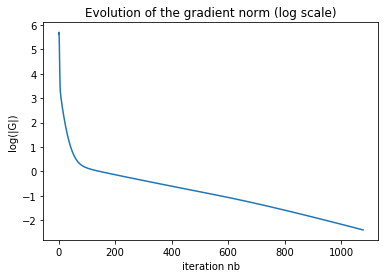

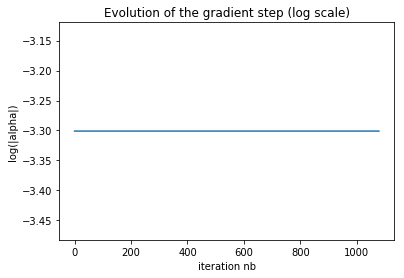

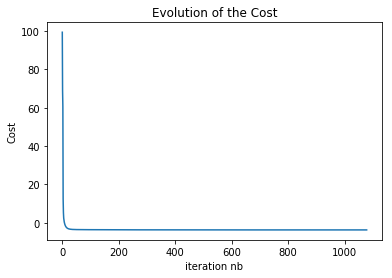

In [9]:
#test
start_time=time.time()
x_opt,F_opt,G_opt,F_tot,G_tot,G_step,nb_iter=GradientFixedStep(qc,5e-4,1e-9)
t=time.time() - start_time

print([nb_iter, F_opt, t])
Visualg(np.log10(G_tot),np.log10(G_step),F_tot)

In [10]:
#Fletcher's algorithm
def Wolfe(alpha0,x,D):
    #alpha is the initial value of the step
    #x is the initial value of the state
    #D is the descent direction
    #The output of this function are alphan (step after the research) and ok (=1
    #if the Wolfe conditions are satisfied, =2 the iterates are undistinguishable)
    
    #Coeffiicent of the line search
    c1=0.01
    c2=0.99
    
    alphamin=0
    alphamax=float('inf')
    
    ok=0
    dltx=1e-9
    
    #Fletcher-Lemarechal algorithm
    F_old,G_old=OraclePG(x,4) #Value of the cost
        
    #Initialization of the algorithm
    alphan=alpha0
    xn=x
    
    stop=0
    while (ok==0 and stop <=100000):
        xp=xn
        xn=x+alphan*D
        F_new,G_new=OraclePG(xn,4)
        
        if F_new>F_old+c1*alphan*np.dot(G_old.T,D):
            alphamax=alphan
            alphan=0.5*(alphamax+alphamin)
        else:
            if np.dot(G_new.T,D)<c2*np.dot(G_old.T,D):
                alphamin=alphan
                if alphamax==float('inf'):
                    alphan=2*alphamin
                else:
                    alphan=0.5*(alphamax+alphamin)
        
        
        if (F_new<=F_old+c1*alphan*np.dot(G_old.T,D) and np.dot(G_new.T,D)>=c2*np.dot(G_old.T,D)):
            ok=1
            
        Norm=np.dot(xn-xp,xn-xp)
        if Norm < dltx:
            ok=2
           
        stop=stop+1
        
    return stop,alphan,ok

In [11]:
#QUESTION 4: Gradient with Wolfe Step
def GradientWolfeStep(qc_0,step,tolerance):
    #x_opt is the value of the state after optimization
    #F_opt is the value of the cost function after optimization
    #G_opt is the value of the gradient after optimization
    #F_tot is the vector where the values of the cost function are stored. 
    #G_tot is the vector where the values of the gradient norm are stored.
    #G_step is the vector where the values of the gradient step are stored.
    
    F_tot=np.array([])
    G_tot=np.array([])
    G_step=np.array([])

    q_k=qc_0
    Norm=float('inf')
    nb_iter=1
    while (Norm > tolerance and nb_iter<10000):
        F,G=OraclePG(q_k,4)
        step=Wolfe(step,q_k,-G)[1]
        q_k1=q_k+step*(-G)
        
        Norm=np.dot(q_k1-q_k,q_k1-q_k)
        q_k=q_k1
        nb_iter+=1
        
        F_tot=np.concatenate((F_tot,np.array([F])),axis=0)
        G_tot=np.concatenate((G_tot,np.array([np.dot(G,G)])),axis=0)
        G_step=np.concatenate((G_step,np.array([step])),axis=0)
        
    x_opt=q_k
    F_opt=F_tot[-1]
    G_opt=G_tot[-1]
    
    return x_opt,F_opt,G_opt,F_tot,G_tot,G_step,nb_iter

[516, -3.733796144004639, 0.07800006866455078]


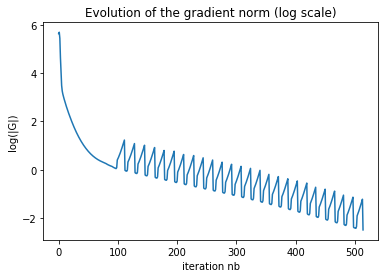

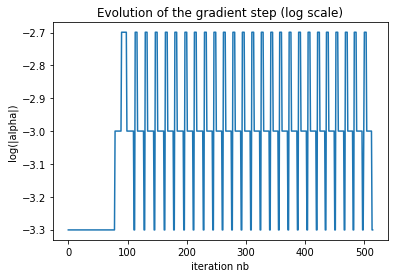

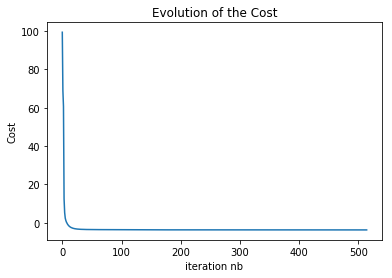

In [12]:
#test
start_time=time.time()
x_opt2,F_opt2,G_opt2,F_tot2,G_tot2,G_step2,nb_iter2=GradientWolfeStep(qc,5e-4,1e-9)
t2=time.time() - start_time

print([nb_iter2, F_opt2, t2])
Visualg(np.log10(G_tot2),np.log10(G_step2),F_tot2)

In [13]:
#QUESTION 5: BFGS
def BFGS(qc_0, step, tolerance): 
    q_k=qc_0
    H_k=np.eye(n-md)
    
    F_tot=np.array([])
    G_tot=np.array([])
    G_step=np.array([])
    
    Norm=float('inf')
    nb_iter=1
    while (Norm > tolerance and nb_iter<10000):
        F,G=OraclePG(q_k,4)
        p_k=-np.dot(H_k,G)
        
        step=Wolfe(step,q_k,p_k)[1]
        q_k1=q_k+step*p_k
        s_k=q_k1-q_k
        y_k=OraclePG(q_k1,3) - G
        
        I=np.eye(n-md)
        den=np.dot(y_k.T,s_k)
        H_k=np.dot(np.dot(I-np.outer(s_k,y_k.T)/den,H_k),I-np.outer(y_k,s_k.T)/den) + np.outer(s_k,s_k.T)/den 
        #np.dot(s_k,y_k.T) gives 1x1 matrix
                
        Norm=np.dot(s_k,s_k)
        q_k=q_k1
        nb_iter+=1
        
        F_tot=np.concatenate((F_tot,np.array([F])),axis=0)
        G_tot=np.concatenate((G_tot,np.array([np.dot(G,G)])),axis=0)
        G_step=np.concatenate((G_step,np.array([step])),axis=0)
        
    x_opt=q_k
    F_opt=F_tot[-1]
    G_opt=G_tot[-1]
    
    return x_opt,F_opt,G_opt,F_tot,G_tot,G_step,nb_iter

[387, -3.7336477609374654, 0.09360027313232422]


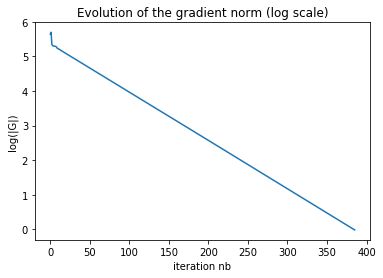

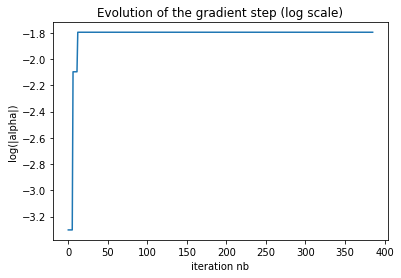

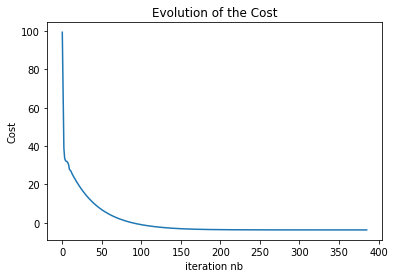

In [14]:
#test
start_time=time.time()
x_opt3,F_opt3,G_opt3,F_tot3,G_tot3,G_step3,nb_iter3=BFGS(qc,5e-4,1e-9)
t3=time.time() - start_time

print([nb_iter3, F_opt3, t3])
Visualg(np.log10(G_tot3),np.log10(G_step3),F_tot3)

In [15]:
#QUESTION 6: Hessian
def OraclePH(qc,ind):
    if ind == 2: 
        f1 = q0 + np.dot(B,qc) 
        f2 = np.multiply(np.multiply(r,q0+np.dot(B,qc)),abs(q0+np.dot(B,qc)))
        f3 = np.dot(Ar,q0+np.dot(B,qc))
        F = 1/3*np.dot(f1,f2) + np.dot(pr,f3)
        return F
              
    elif ind == 3: 
        f2 = np.multiply(np.multiply(r,q0+np.dot(B,qc)),abs(q0+np.dot(B,qc)))
        G = np.dot(B.T,f2) + np.dot(np.dot(Ar,B).T,pr)
        return G
    
    elif ind == 4: 
        f1 = q0 + np.dot(B,qc) 
        f2 = np.multiply(np.multiply(r,q0+np.dot(B,qc)),abs(q0+np.dot(B,qc)))
        f3 = np.dot(Ar,q0+np.dot(B,qc))
        F = 1/3*np.dot(f1,f2) + np.dot(pr,f3)
        G = np.dot(B.T,f2) + np.dot(np.dot(Ar,B).T,pr)
        
        h1 = np.multiply(2*r,abs(q0+np.dot(B,qc)))
        H = np.dot(np.dot((2*B).T,np.diag(h1)),B)
        return F, G, H

In [16]:
#QUESTION 7: Newton
def Newton(qc_0,tolerance, ind): 
    F_tot=np.array([])
    G_tot=np.array([])
    G_step=np.array([])
    
    q_k=qc_0
    Norm=float('inf')
    nb_iter=1
    
    while (Norm > tolerance and nb_iter<10000): 
        F,G,H=OraclePH(q_k,4)
        p_k=-np.dot(inv(H),G)
        if ind == 'fixed': 
            step=1
        elif ind == 'Wolfe': 
            step=Wolfe(1,q_k,p_k)[1]
            
        q_k1=q_k+step*p_k
        
        Norm=np.dot(q_k1-q_k,q_k1-q_k)
        q_k=q_k1
        nb_iter+=1
        
        F_tot=np.concatenate((F_tot,np.array([F])),axis=0)
        G_tot=np.concatenate((G_tot,np.array([np.dot(G,G)])),axis=0)
        G_step=np.concatenate((G_step,np.array([step])),axis=0)
    
    x_opt=q_k
    F_opt=F_tot[-1]
    G_opt=G_tot[-1]
    
    return x_opt,F_opt,G_opt,F_tot,G_tot,G_step, nb_iter

[17, -3.7340066990646488, 0.0]


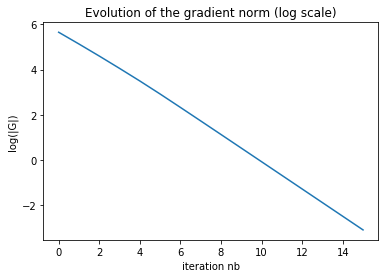

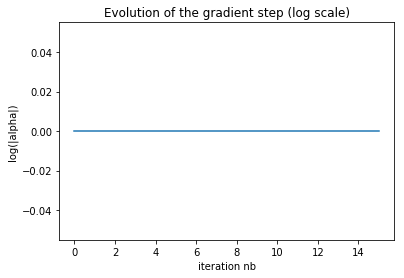

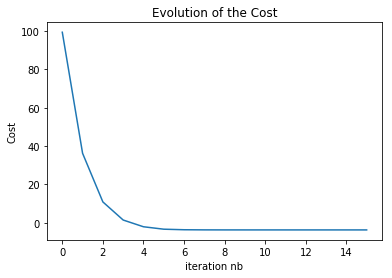

In [17]:
#test Newton with fixed step
start_time=time.time()
x_opt4,F_opt4,G_opt4,F_tot4,G_tot4,G_step4, nb_iter4=Newton(qc,1e-9,'fixed')
t4=time.time() - start_time

print([nb_iter4, F_opt4, t4])
Visualg(np.log10(G_tot4),np.log10(G_step4),F_tot4)

[17, -3.7340066990646488, 0.0]


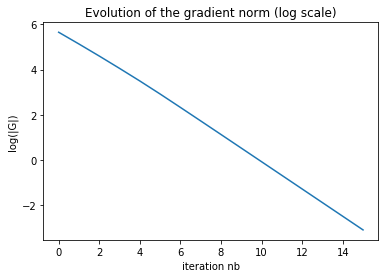

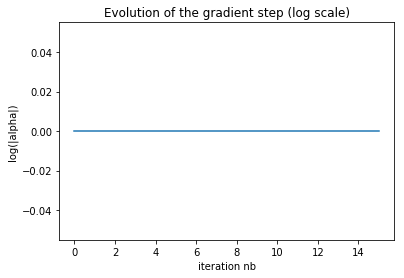

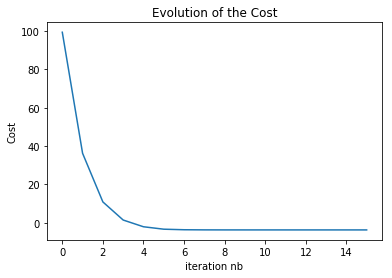

In [18]:
#test Newton with Wolfe step
start_time=time.time()
x_opt5,F_opt5,G_opt5,F_tot5,G_tot5,G_step5, nb_iter5=Newton(qc,1e-9,'Wolfe')
t5=time.time() - start_time

print([nb_iter5, F_opt5, t5])
Visualg(np.log10(G_tot5),np.log10(G_step5),F_tot5)

In [19]:
#QUESTION 8: Python Built-in Functions
def OracleF(qc):
    f1 = q0 + np.dot(B,qc) 
    f2 = np.multiply(np.multiply(r,q0+np.dot(B,qc)),abs(q0+np.dot(B,qc)))
    f3 = np.dot(Ar,q0+np.dot(B,qc))
    F = 1/3*np.dot(f1,f2) + np.dot(pr,f3)
    return F
              
def OracleG(qc):
    f2 = np.multiply(np.multiply(r,q0+np.dot(B,qc)),abs(q0+np.dot(B,qc)))
    G = np.dot(B.T,f2)+np.dot(np.dot(Ar,B).T,pr)
    return G
    
def OracleH(qc):
    f1 = q0 + np.dot(B,qc) 
    h1 = 2*np.multiply(r,f1)
    H = 2*np.dot(np.dot(B.T,np.diag(h1)),B)
    return H

In [20]:
start_time=time.time()
resBFGS=minimize(OracleF, qc, method='BFGS', jac=OracleG, options={'disp':True})
print(time.time() - start_time)

Optimization terminated successfully.
         Current function value: -3.734007
         Iterations: 24
         Function evaluations: 29
         Gradient evaluations: 29
0.0


In [21]:
start_time=time.time()
resN=minimize(OracleF, qc, method='Newton-CG',jac=OracleG, hess=OracleH,options={'xtol': 1e-9, 'disp': True})
print(time.time() - start_time)

Optimization terminated successfully.
         Current function value: -3.734007
         Iterations: 453
         Function evaluations: 546
         Gradient evaluations: 998
         Hessian evaluations: 453
0.12480020523071289


In [22]:
print('Gradient Fixed:', [F_opt, nb_iter, t] )
print('Gradient Wolfe:', [F_opt2, nb_iter2, t2] )
print('BFGS Wolfe:', [F_opt3, nb_iter3, t3] )
print('Newton fixed:', [F_opt4, nb_iter4, t4] )
print('Newton Wolfe:', [F_opt5, nb_iter5, t5] )

Gradient Fixed: [-3.733725543739137, 1080, 0.062400102615356445]
Gradient Wolfe: [-3.733796144004639, 516, 0.07800006866455078]
BFGS Wolfe: [-3.7336477609374654, 387, 0.09360027313232422]
Newton fixed: [-3.7340066990646488, 17, 0.0]
Newton Wolfe: [-3.7340066990646488, 17, 0.0]
